In [1]:
import datetime as dt
import sqlite3
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from matplotlib.ticker import MaxNLocator

In [2]:
con = sqlite3.connect('employee.db')

In [3]:
def get_department_by_boss(boss_id: int) -> int:
    """Рекурсивная функция для получения идентификатора отдела по идентификатору боса.
    
    Фкатически идентификатор отдела равен идентификатору боса отдела.
    Босы отделов являются верхнеуровными босами.
    
    Args:
        boss_id: идентификатор боса.

    Returns:
        Идентификатор отдела.
    """
    employee_id, _, boss = next(con.cursor().execute(f'SELECT * FROM employees WHERE id = {boss_id};'))
    if boss:
         return get_department_by_boss(boss)

    return employee_id


def get_employees() -> pd.DataFrame:
    """Получить датафрейм с информацией о сотрудниках.

    Использует sqlite для открытия дампа БД, берет оттуда нужные данные и кладет в датафрэйм.
    Датафрэйм содержит идентификатор сотрудника, имя сотрудника и идентификатор отдела, где сотрудник работает.

    Returns:
        Датафрэйм с информацией о сотрудниках.
    """
    employees_df = pd.DataFrame({'employee_id': [], 'name': [], 'department_id': []})
    for employee_id, name, boss_id in con.cursor().execute("SELECT id as employee_id, name, boss_id FROM employees;"):
        employees_df.loc[len(employees_df.index)] = {
            'employee_id': employee_id,
            'name': name,
            'department_id': employee_id if boss_id is None else get_department_by_boss(boss_id)
        }
    return employees_df


In [4]:
def parse_events(employees_df: pd.DataFrame) -> pd.DataFrame:
    """Парсит файл с событиями и кладет данные в датафрэйм.

    Датафрэйм содержит имя сотрудника, дату события, тип события и идентификатор отдела.
    Идентификатор берем из датафрэйма с сотрудниками по имени боса, или имени сотрудника если в событии не указан бос.

    Args:
        employees_df: датафрэйм с сотрудниками.

    Returns:
        Отсортированный по дате датафрэйм с событиями.
    """
    with open("events.txt", "r") as f:
        f_content = f.read().split("---")
        
    events_df = pd.DataFrame({'name': [], 'date': [], 'action': [], 'department': np.array([], dtype="int64")})
    for event in f_content:
        event_row = {}
        for line in event.split('\n'):
            if len(line.strip()) == 0:
                continue

            if line.startswith('Name: '):
                event_row['name'] = line.lstrip('Name: ')

            elif line.startswith('Date: '):
                event_row['date'] = line.lstrip('Date: ')

            elif line.startswith('Boss: '):
                boss = line.lstrip('Boss: ')
                boss_series = employees_df.loc[employees_df.name == boss]
                if boss_series.size != 0:
                    event_row['department'] = boss_series.department_id.values[0]

            else:
                event_row['action'] = line

        if not event_row:
            continue

        if 'department' not in event_row:
            emp_series = employees_df.loc[employees_df.name == event_row['name']]
            if emp_series.size != 0:
                event_row['department'] = emp_series.department_id.values[0]

        events_df.loc[len(events_df.index)] = event_row

    return events_df.sort_values(by='date')


In [5]:
employees_df = get_employees()
events_df = parse_events(employees_df=employees_df)

# Определяем самую ранню и самую позднюю дату известных событий
begin_date = dt.datetime.strptime(events_df.iloc[0].date, '%Y-%m-%d').date()
end_date = dt.datetime.strptime(events_df.iloc[-1].date, '%Y-%m-%d').date()

In [6]:
def get_last_department_by_name_and_date(events_df: pd.DataFrame, name: str, date: str) -> Optional[int]:
    """Получить идентификатор отдела по предыдущему событию сотрудника.
    
    Args:
        events_df: датафрэйм с событиями.
        name: имя сотрудника.
        date: дата, ранее которой нужно искать события.

    Returns:
        Идентификатор отдела, если есть искомое событие, иначе None.
    """
    prev_event_series = events_df[(events_df.name == name) & (events_df.date < date)].tail(1)
    if prev_event_series.size == 0:
        return

    return prev_event_series.department.values[0]

In [7]:
# Берем стартовые данные по количеству сотрудников по отделам.
# Предполагается, что это текущие актуальные данные, поэтому они являются данными на последнюю неделю
start_count = employees_df.groupby('department_id').count().to_dict()['employee_id']
staff_count = [start_count]

cur_count = start_count.copy()
cur_date = end_date
# Так как начинаем рассчёт с последней недели, итерируем отнимая по недели от обрабатываемой даты пока не доберемся до начальной
while cur_date > begin_date:
    cur_date_str = cur_date.strftime('%Y-%m-%d')
    cur_date = cur_date - relativedelta(weeks=1)
    next_date_str = cur_date.strftime('%Y-%m-%d')

    # Берем данные за конкретную неделю
    events_chunk = events_df[(events_df.date > next_date_str) & (events_df.date < cur_date_str)]
    for _, row in events_chunk.iterrows():
        if row.action == 'Transfer':
            prev_department = get_last_department_by_name_and_date(events_df=events_df, name=row.name, date=row.date)
            if prev_department:
                # Если возможно определить предыдущий отдел прибавляем туда сотрудника и убираем из текущего.
                cur_count[prev_department] = cur_count.get(prev_department, 0) + 1
                cur_count[row.department] = cur_count.get(row.department, 0) - 1
            continue

        if row.action == 'Hire':
            # В случае найма отнимаем сотрудника от текущего отдела
            cur_count[row.department] = cur_count.get(row.department, 0) - 1
            continue

        if row.action == 'Fire':
            prev_department = get_last_department_by_name_and_date(events_df=events_df, name=row.name, date=row.date)
            if prev_department:
                # В случае увольнения и наличия сведений о предыдущем отделе прибавляем туда сотрудника
                cur_count[prev_department] = cur_count.get(prev_department, 0) + 1

    staff_count.append(cur_count)
    cur_count = cur_count.copy()


In [8]:
# Формируем координаты для графика на основе обработаных данных
weeks = []
dep_1 = []
dep_2 = []
dep_3 = []
dep_4 = []
dep_5 = []
dep_6 = []
dep_7 = []
dep_8 = []
dep_9 = []
dep_10 = []

for week, staff in enumerate(reversed(staff_count)):
    weeks.append(week)
    dep_1.append(staff[1])
    dep_2.append(staff[2])
    dep_3.append(staff[3])
    dep_4.append(staff[4])
    dep_5.append(staff[5])
    dep_6.append(staff[6])
    dep_7.append(staff[7])
    dep_8.append(staff[8])
    dep_9.append(staff[9])
    dep_10.append(staff[10])


In [9]:
def build_graph(x: List[int], y: List[int], title: str) -> None:
    """Функция для постройки графика на основе переданных данных.

    Args:
        x: список координат по оси x (они же недели).
        y: список координат по оси y (оно же количество сотрудников).
        title: название графика.
    """
    plt.figure(figsize=(10, 5))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel("Weeks")
    plt.ylabel("Staff")
    plt.title(title)
    plt.plot(x, y, 'b-')
    plt.grid(True)
    plt.show()
    

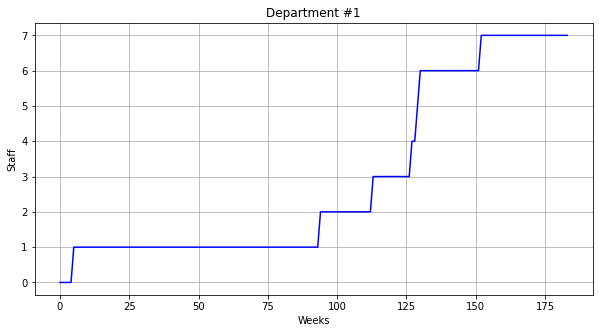

In [10]:
build_graph(x=weeks, y=dep_1, title='Department #1')

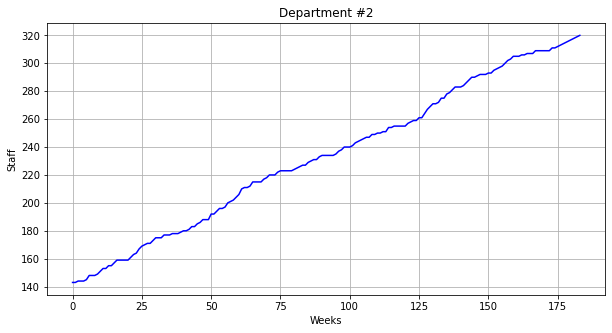

In [11]:
build_graph(x=weeks, y=dep_2, title='Department #2')

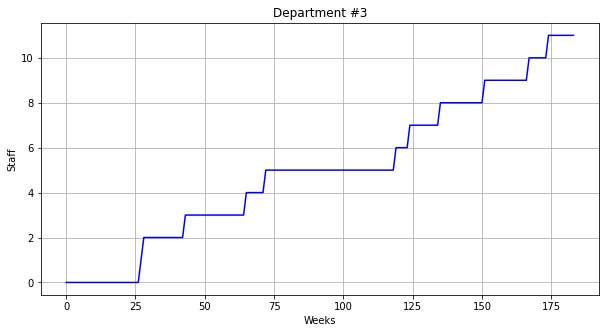

In [12]:
build_graph(x=weeks, y=dep_3, title='Department #3')

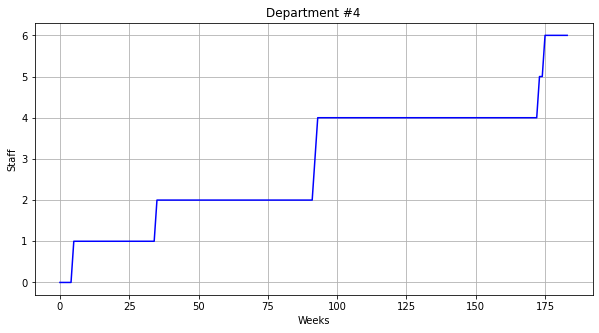

In [13]:
build_graph(x=weeks, y=dep_4, title='Department #4')

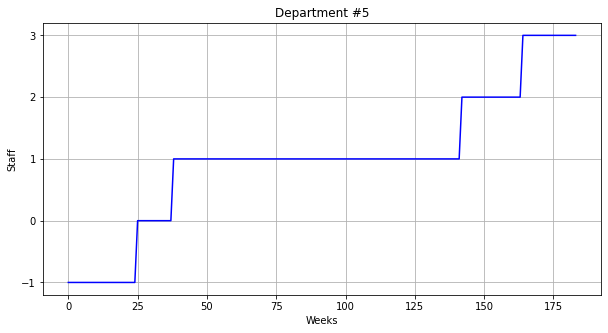

In [14]:
# Отрицательное количество сотрудников (
# Вероятно, я не понял всю глубину задачи, ну или это из за недостатка данных о событиях
build_graph(x=weeks, y=dep_5, title='Department #5')

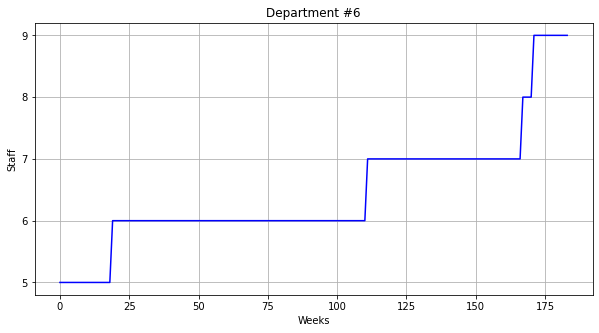

In [15]:
build_graph(x=weeks, y=dep_6, title='Department #6')

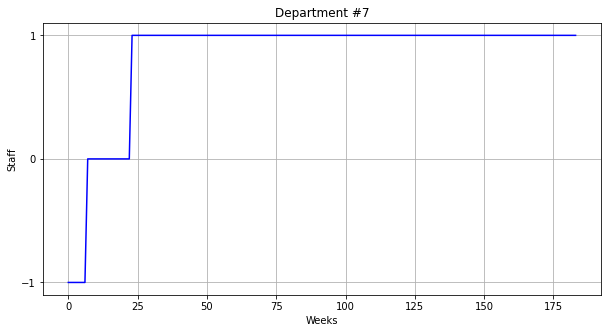

In [16]:
build_graph(x=weeks, y=dep_7, title='Department #7')

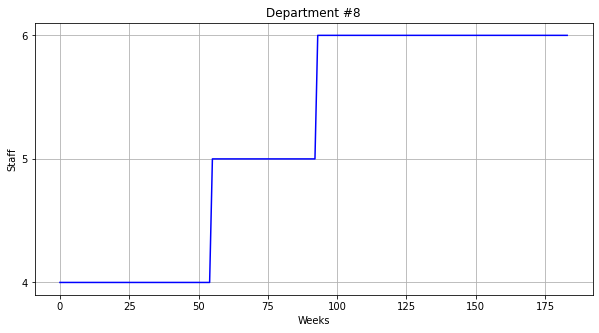

In [17]:
build_graph(x=weeks, y=dep_8, title='Department #8')

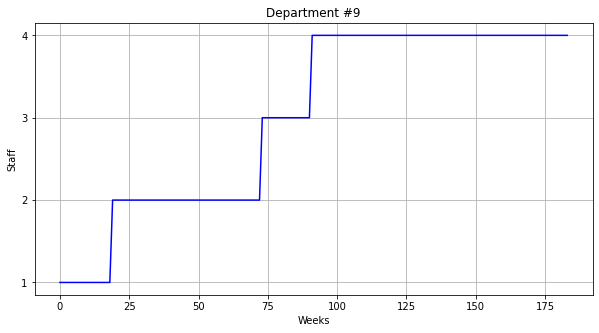

In [18]:
build_graph(x=weeks, y=dep_9, title='Department #9')

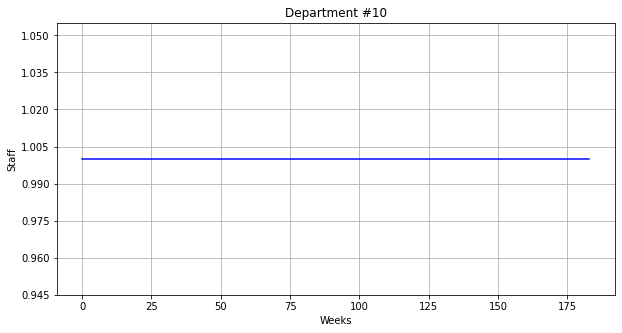

In [19]:
build_graph(x=weeks, y=dep_10, title='Department #10')